# Exam No 2 

This is the second exam for DS405B submitted by Nico Schwarzer, ID: 5632297.

## Loading in data and Word embeddings

In [ ]:
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from torchtext.vocab import GloVe, vocab

In [ ]:
import torch 
from torch import nn 
import torchtext
from torch.utils.data import DataLoader
from numpy import dot
from numpy.linalg import norm
import random as rng
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd 
import math
from torchtext.vocab import GloVe, vocab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
data_raw = pd.read_csv("/content/gdrive/My Drive/DS Project/data_for_BERT.csv")

data_raw.head()

NameError: ignored

In [ ]:
## splitting in training and validation set
rng.seed(5)

train_data_raw = data_raw.sample(n = math.ceil( 0.9*data_raw.shape[0]), replace = False, random_state = 123)
val_data_raw = data_raw.drop(train_data_raw.index)


In [ ]:
## calling Dataset class 

train_data  = Text_as_Dataset(train_data_raw)
val_data  = Text_as_Dataset(val_data_raw)


In [ ]:
class Text_as_Dataset(Dataset):

    ''' This class transforms the input data to a useable dataset, which can be passed 
    to PyTorch's dataloader class.''' 
    
    def __init__(self, df):
        # also defining default value # 

        # data as Pytorch tensors via the collate batches function 
        self.data = np.array(df)

    def __getitem__(self, idx):
        return (self.data[idx][0], self.data[idx][1])
        
    def __len__(self):
        return(self.data.shape[0])

In [ ]:
## loading 100-dim Glove embeddings 

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove*.zip

--2021-12-19 09:07:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-19 09:07:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-19 09:07:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'word2vec.txt'

glove2word2vec(glove_input_file, word2vec_output_file)
model_w2v = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)


Next, I shall create a vocabulary based on the training dataset that only contains words that are also present in the glove vocabulary. This is why I retrieve all words contained on the glove vocab and sort them out before calling the build_vocab_from_iterator() function. 

In [ ]:
tokenizer = get_tokenizer('basic_english')
list_glove_words = list(model_w2v.vocab)

def yield_token(data_iter): ## merely tokenizes the text per batch

  for label_class, text in data_iter:
  # only keeping those words which appear in glove vocabulary
    token_text = tokenizer(text)
    text_reduced = [x for x in token_text if x in list_glove_words]
  
    yield text_reduced # only using text, not labels

vocab = build_vocab_from_iterator(yield_token(train_data), specials = ["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
## saving the vocabulary

torch.save(vocab, '/content/gdrive/My Drive/DS405B_NLP/Ex_2/vocab.pth')

Next, I shall set up a matrix containing the pretrained embeddings for all words as well as random embedding for the words not contained, e.g. the pad token. These will recieve random embeddings. This ensures that the word-ordering of the word embeddings matches that of the vocabulary.

In [ ]:
## getting 100 - dim embedding per word in vocab 
## only for those words in the vocab, else random embdedding


embed_matrix_len = len(vocab)
embed_matrix = np.ones((embed_matrix_len, 100 ))

for i, word in enumerate(vocab.get_itos() ):
  try:
    embed_matrix[i,] = model_w2v[word]
  except:
    embed_matrix[i,] = np.random.normal( size=(100, ))

In [ ]:
# saving the embeddings 

np.savetxt(fname="/content/gdrive/My Drive/DS405B_NLP/Ex_2/embed_matrix.csv", delimiter=",", X=embed_matrix)


Now, the collate batch function is implemented. The labels are mapped to one-hot lists and the texts will be padded to the maximum text length per batch. The padding value is set to the index of the pad token in the vocabulary. Also, the actual length of the texts are put out since these are needed for the pack_padded_sequence function later on.

In [ ]:
## finding index fpr <pad> in the vocab 
index_pad = vocab.lookup_indices(["<pad>"])[0]


def collate_batch(batch):
  label_list, text_list, lengths = [], [], []
  for (label, text) in batch:
    if label == "sadness":
      label_list.append([1,0,0,0])
    elif label == "worry":
      label_list.append([0,1,0,0])
    elif label == "neutral":
      label_list.append([0,0,1,0])
    elif label == "happiness":
      label_list.append([0,0,0,1])
      
    processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.float32) # dim for each label/text pair in batch -> size of tokens per text
    text_list.append(processed_text)
    lengths.append(len(processed_text))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=index_pad) # batch size * size of longest sequence (others padded)
  lengths =  torch.tensor(lengths)

  return text_list, label_list, lengths


train_dataloader = DataLoader(train_data, batch_size=128, collate_fn=collate_batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=128, collate_fn=collate_batch, shuffle= True)


## Model Architecture

The nextwork architecture (excluding all type of regularization) will look as follows. It shall be based on a bidirectionaly LSTM followed by two fully connected layers. Importanty, I shall freeze the pretrained word embeddings.

In [ ]:
class my_LSTM_regu(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, drop_out, num_layer):
    # embedding dim is pre-specified  - I shall use 100 
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embed_matrix).float(), freeze=True)

    self.num_layer = num_layer
    self.lstm = nn.LSTM(embed_matrix.shape[1],  hidden_size = hidden_dim, num_layers = num_layer, bidirectional = True, batch_first=True, dropout = drop_out)

    # 2 hidden dima backwards and forwards - need to be concatinated, 2bc of bi-directional
    self.fc1 = nn.Linear(2*hidden_dim, 4)


  def forward(self, text, lengths):
    # text: batch_Size X sequence lenght
    embedded = self.embedding(text) # embedded: batch_size X sequence length X embedding dimension

    packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

    # pack embedded contains the packed embeddings without the the padding tokens alongside the lengths and changing dimensions!
    #tensor([[1, 2, 3],
    #    [3, 4, 0]])

    # becomes data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1])  or size is sum of all sequence lengths in batch * embedding dimension

    
    output, [hidden, cell] = self.lstm(packed_embedded) 
    #hidden: 2 (number if directions) X batch_size X hidden dimension

    return  self.fc1(  torch.cat((hidden[-2*self.num_layer,:,:], hidden[-1*self.num_layer,:,:]), dim = 1  ) )

    # torch cat output -> first in argument - direction 1 / second in argument -> direction 2 (each of dimension batch size * hiddem dimension)
    # shape -> batch size * (hidden dim * 2)

    # final output of fc1 -> batch size * 4 :D 


    
    

# Model Training 

Now, the model is trained. I shall be following the optimization procedure as laid out in the lecture. 

## Step 1: Overfit a small number of examples.

For a subset of the overall data available, I shall try to reach ~ 100% training accuracy (here Macro F1)! The 10 minibatches are drawn at random with a random seed ensuring that the same ones are drawn. 

In [ ]:
## getting new dataoader for fewer data

train_data_raw_reduced = train_data_raw.sample(n = math.ceil(0.1 * train_data_raw.shape[0]) )
train_data_reduced  = Text_as_Dataset(train_data_raw_reduced)
train_dataloader_reduced = DataLoader(train_data_reduced, batch_size=128, collate_fn=collate_batch, shuffle=True)



In [ ]:
import torch 

INPUT_DIM = len(vocab)
HIDDEN_DIM = 40
OUTPUT_DIM = 4
DROPOUT = 0
NUM_LAYER = 2

model = my_LSTM_regu(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, NUM_LAYER)

device = torch.device("cuda")
model = model.to(device)


In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Acc. to Pytorch Documentation: The input is expected to contain raw, unnormalized scores for each class.
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [ ]:
from sklearn.metrics import f1_score

Note that the running loss as well as the F1 per epoch (so the f1 of the X batches within each epoch) are returned.

In [ ]:
num_epochs = 60

f1_epoch = []
train_running_loss = []

for epoch in range(num_epochs):

  argmax_labels = []
  argmax_outputs = []


  for (text, labels,  lengths) in train_dataloader_reduced:
    f1_batch = []

    optimizer.zero_grad()
    output = model(text.long().embeddings_yahoo_2 = model_2.encode(list(yahoo_df_train.text))
, lengths).squeeze(1)
    loss = criterion(output, labels.to(device)) 
    loss.backward()
    optimizer.step()
    train_running_loss.append(loss.item())

    argmax_labels.append( list(np.argmax(labels.cpu().detach().numpy(), axis = 1) ))    
    argmax_outputs.append( list(np.argmax(output.cpu().detach().numpy(), axis = 1) ))  
    
  argmax_labels_all = [item for sublist in argmax_labels for item in sublist]
  argmax_outputs_all = [item for sublist in argmax_outputs for item in sublist]


    # f1 per batch

  f1_here = f1_score(argmax_labels_all, argmax_outputs_all, labels = [0,1,2,3], average = "macro")
  f1_epoch.append(f1_here)


  print(f'Epoch {epoch} Mean Running Training Loss: {np.mean(train_running_loss)}')
  print(f'Epoch {epoch} Macro F1 of this epoch: {f1_epoch[-1]}')
  


Epoch 0 Mean Running Training Loss: 1.3575468328264024
Epoch 0 Macro F1 of this epoch: 0.186405183122216
Epoch 1 Mean Running Training Loss: 1.3465451432598963
Epoch 1 Macro F1 of this epoch: 0.2356688876267679
Epoch 2 Mean Running Training Loss: 1.3339972231123183
Epoch 2 Macro F1 of this epoch: 0.2755471994985258
Epoch 3 Mean Running Training Loss: 1.3189420286152098
Epoch 3 Macro F1 of this epoch: 0.3172303099359745
Epoch 4 Mean Running Training Loss: 1.3038639068603515
Epoch 4 Macro F1 of this epoch: 0.37699433530415244
Epoch 5 Mean Running Training Loss: 1.2867444643267878
Epoch 5 Macro F1 of this epoch: 0.38151923565609025
Epoch 6 Mean Running Training Loss: 1.2705623810253446
Epoch 6 Macro F1 of this epoch: 0.4170099615274603
Epoch 7 Mean Running Training Loss: 1.2554875794384215
Epoch 7 Macro F1 of this epoch: 0.44853142506429483
Epoch 8 Mean Running Training Loss: 1.2414733039008246
Epoch 8 Macro F1 of this epoch: 0.4738567707801694
Epoch 9 Mean Running Training Loss: 1.227749

The architecture above seems to realize a really high Macro F1 Score. The first step of optimizing is hence done! I shall save this first model.

## Step 2: Find Learning rate that makes loss go down

I shall now use all data, the architecture of the last model and turn un dropout and evaluate the model on the test set find a learning rate that decreases the validation loss greatly within 70 iterations. Also, I shall use the AMAMW optimiser, which can incorporate a weight decay.

In [ ]:

INPUT_DIM = len(vocab)
HIDDEN_DIM = 40
OUTPUT_DIM = 4
DROPOUT = 0.2
NUM_LAYER = 2

model = my_LSTM_regu(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT, NUM_LAYER)

device = torch.device("cuda")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # Acc. to Pytorch Documentation: The input is expected to contain raw, unnormalized scores for each class.
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-3)


In [ ]:
#import random
#random.seed(5)

num_epochs = 70
f1_eval_epoch = []
overall_train_loss = []
overall_val_loss = []

for epoch in range(num_epochs):

  argmax_labels = []
  argmax_outputs = []

  model.train()
  train_running_loss = []
  for (text, labels,  lengths) in train_dataloader:

    optimizer.zero_grad()
    output = model(text.long().to(device), lengths).squeeze(1)
    loss = criterion(output, labels.to(device) )
    loss.backward()
    optimizer.step()
    train_running_loss.append(loss.item())

  # evaluating on eval set 
  #with torch.no_grad():
  
  model.eval()
  validation_running_loss = []
  with torch.no_grad():
  
    for (text, labels,  lengths) in  val_dataloader:
      f1_batch = []
      output = model(text.long().to(device), lengths).squeeze(1) 
      loss = criterion(output, labels.to(device)) 
      validation_running_loss.append(loss.item())
      
      argmax_labels.append( list(np.argmax(labels.cpu().detach().numpy(), axis = 1) ))   
      argmax_outputs.append( list(np.argmax(output.cpu().detach().numpy(), axis = 1) )) 

  overall_val_loss.append(np.mean(validation_running_loss))

  argmax_labels_all = [item for sublist in argmax_labels for item in sublist]
  argmax_outputs_all = [item for sublist in argmax_outputs for item in sublist]


    # f1 per batch

  f1_here = f1_score(argmax_labels_all, argmax_outputs_all, labels = [0,1,2,3], average = "macro")
  f1_epoch.append(f1_here)


  print(f'Epoch {epoch} Validation Loss: {overall_val_loss[-1]}')
  print(f'Epoch {epoch} Macro F1 of this epoch: {f1_epoch[-1]}')
  
 


Epoch 0 Validation Loss: 1.349463313817978
Epoch 0 Macro F1 of this epoch: 0.21912709058096302
Epoch 1 Validation Loss: 1.3296262621879578
Epoch 1 Macro F1 of this epoch: 0.2648996833433559
Epoch 2 Validation Loss: 1.275704663991928
Epoch 2 Macro F1 of this epoch: 0.3284150530651308
Epoch 3 Validation Loss: 1.2461912035942078
Epoch 3 Macro F1 of this epoch: 0.36011037576065485
Epoch 4 Validation Loss: 1.2254813253879546
Epoch 4 Macro F1 of this epoch: 0.3604648202852239
Epoch 5 Validation Loss: 1.2174838185310364
Epoch 5 Macro F1 of this epoch: 0.3743974245353551
Epoch 6 Validation Loss: 1.2066702902317048
Epoch 6 Macro F1 of this epoch: 0.3842849106225573
Epoch 7 Validation Loss: 1.200912481546402
Epoch 7 Macro F1 of this epoch: 0.37961039997102086
Epoch 8 Validation Loss: 1.1981333494186401
Epoch 8 Macro F1 of this epoch: 0.38319475600991443
Epoch 9 Validation Loss: 1.1934329569339752
Epoch 9 Macro F1 of this epoch: 0.3854614550889217
Epoch 10 Validation Loss: 1.1875666975975037
Epoc

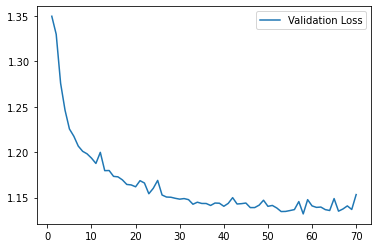

In [ ]:
# plotting number of epochs vs. training and evaluaiton loss per epoch!
import matplotlib.pyplot as plt

epochs = list(range(1,71))

plt.plot(epochs, overall_val_loss)
plt.legend(["Validation Loss"], loc='upper right')
plt.show()


A learning rate of 1e-4 does seem to work for reducing both the training and the validation loss.


## Step 3: Coarse grid search

Next, I shall play around with some useful weight decay numbers and some useful dropout strength  hyperparameters to find optimal ones. The learning rate is kept at 1e-4 to allow for precise updates. Therefore, I shall see how the model performs in the first 30 epochs.

In [ ]:
weight_decay = [1e-2, 1e-3, 1e-4]
dropouts = [0.15, 0.2]

# matrix for outputs 
output_step_3 = np.ones([30,6])

In [ ]:
# counter for filling in columns 
i = 0 

for w in weight_decay:
  for drop in dropouts:


    print(f"Weigth decay:{w}")
    print(f"Dropout:{drop}")
      
    # defining model & optimizer
    model = my_LSTM_regu(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, drop, NUM_LAYER)
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss() # Acc. to Pytorch Documentation: The input is expected to contain raw, unnormalized scores for each class.
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = w)


    # training & evaluating model 
    num_epochs = 30
    overall_val_loss = []

    for epoch in range(num_epochs):

      model.train()
      for (text, labels,  lengths) in train_dataloader:

        optimizer.zero_grad()
        output = model(text.long().to(device), lengths).squeeze(1) # cpu().
        loss = criterion(output, labels.to(device) )    #.to(device))
        loss.backward()
        optimizer.step()
       
      model.eval()
      validation_running_loss = []
      with torch.no_grad():
    
        for (text, labels,  lengths) in  val_dataloader:
          output = model(text.long().to(device), lengths).squeeze(1)  # .to(device)
          loss = criterion(output, labels.to(device)) #  .to(device)) 
          validation_running_loss.append(loss.item())


      overall_val_loss.append(np.mean(validation_running_loss))

    # filling in result matrix
    output_step_3[:,i] = overall_val_loss

      
    i += 1




Weigth decay:0.01
Dropout:0.15
Weigth decay:0.01
Dropout:0.2
Weigth decay:0.001
Dropout:0.15
Weigth decay:0.001
Dropout:0.2
Weigth decay:0.0001
Dropout:0.15
Weigth decay:0.0001
Dropout:0.2


Now, one can take a look at the validation losses to find the best combination.

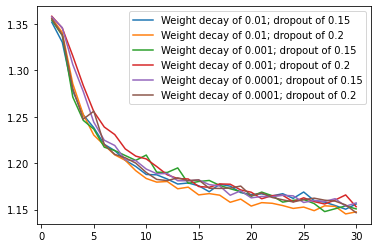

In [ ]:
## Plotting outputs 

epochs = list(range(1,31))
plt.plot(epochs, output_step_3[:,0])
plt.plot(epochs, output_step_3[:,1])
plt.plot(epochs, output_step_3[:,2])
plt.plot(epochs, output_step_3[:,3])
plt.plot(epochs, output_step_3[:,4])
plt.plot(epochs, output_step_3[:,5])

# adding legend
labels = []
for w in weight_decay:
  for drop in dropouts:
    labels.append(str("Weight decay of " + str(w) + "; dropout of " + str(drop) ) )


plt.legend(labels, loc='upper right')
plt.show()

Based on th grpah above, the best combination seems to be a weight decay of 1e-2 and a dropout of 0.2 (orange line).

## Step 4: Fine grid search

Now, I shall keep the aritecture with a weight decay of 1e-2 and a dropout of 0.2 and do a grid search for the hidden dimension and the number of layers as these seem to have a large impact on the model performance. Especially given the limited GPU usage, it makes sense to focus on those hyper-parameters which do have a large effect on performance.  Again, I shall train each model for 30 iterations and compare the respective validation losses. 

In [ ]:
weight_decay = 1e-2
dropout = 0.2

hidden_dims = [40, 80, 120]
num_layer = [2,3]

# matrix for outputs 
output_step_4 = np.ones([30,6])

In [ ]:
# counter for filling in columns 
i = 0 

for h in hidden_dims:
  for num in num_layer:


    print(f"Hiddem Dim:{h}")
    print(f"Number of Layers:{num}")
      
    # defining model & optimizer
    model = my_LSTM_regu(INPUT_DIM, h, OUTPUT_DIM, dropout, num)
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss() # Acc. to Pytorch Documentation: The input is expected to contain raw, unnormalized scores for each class.
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = weight_decay)


    # training & evaluating model 
    num_epochs = 30
    overall_val_loss = []

    for epoch in range(num_epochs):

      model.train()
      for (text, labels,  lengths) in train_dataloader:

        optimizer.zero_grad()
        output = model(text.long().to(device), lengths).squeeze(1) # cpu().
        loss = criterion(output, labels.to(device) )    #.to(device))
        loss.backward()
        optimizer.step()
       
      model.eval()
      validation_running_loss = []
      with torch.no_grad():
    
        for (text, labels,  lengths) in  val_dataloader:
          output = model(text.long().to(device), lengths).squeeze(1)  # .to(device)
          loss = criterion(output, labels.to(device)) #  .to(device)) 
          validation_running_loss.append(loss.item())


      overall_val_loss.append(np.mean(validation_running_loss))

    # filling in result matrix
    output_step_4[:,i] = overall_val_loss

    i += 1


Hiddem Dim:40
Number of Layers:2
Hiddem Dim:40
Number of Layers:3
Hiddem Dim:80
Number of Layers:2
Hiddem Dim:80
Number of Layers:3
Hiddem Dim:120
Number of Layers:2
Hiddem Dim:120
Number of Layers:3


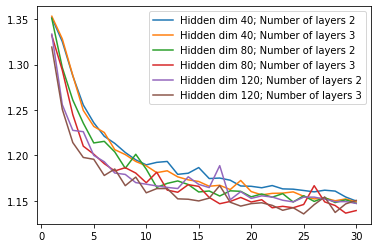

In [ ]:
## Plotting outputs 

epochs = list(range(1,31))
plt.plot(epochs, output_step_4[:,0])
plt.plot(epochs, output_step_4[:,1])
plt.plot(epochs, output_step_4[:,2])
plt.plot(epochs, output_step_4[:,3])
plt.plot(epochs, output_step_4[:,4])
plt.plot(epochs, output_step_4[:,5])

# adding legend
labels = []
for h in hidden_dims:
  for num in num_layer:
    labels.append(str("Hidden dim " + str(h) + "; Number of layers " + str(num) ) )

plt.legend(labels, loc='upper right')
plt.show()

It seems as if the bidirectional LSTM with a hidden dimension of 80 and 3 layers (red line) is performing the best.

## Training 'best' model

Now that I have found 'optimal' hyper-parameters, it is time to train the model with the latter and save it afterwards. I shall also implement an adaptive learning rate regime and early stopping to make smaller and more accurate gradient descent steps and to avoid overfitting. If the current validation loss is higher than that of two preceding epochs, the learning rate is lowered to 1e-5 and if after this step the  validation loss is again higher than that of the two preceding epochs, the learning is stopped.


In [ ]:
INPUT_DIM = len(vocab)
BEST_HIDDEN_DIM = 80
OUTPUT_DIM = 4
BEST_DROPOUT = 0.2
BEST_NUM_LAYER = 3
BEST_LR = 1e-4
BEST_DECAY = 1e-3

model = my_LSTM_regu(INPUT_DIM, BEST_HIDDEN_DIM, OUTPUT_DIM, BEST_DROPOUT, BEST_NUM_LAYER)

device = torch.device("cuda")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # Acc. to Pytorch Documentation: The input is expected to contain raw, unnormalized scores for each class.
optimizer = torch.optim.AdamW(model.parameters(), lr = BEST_LR, weight_decay = BEST_DECAY)


In [ ]:
num_epochs = 100
f1_epoch = []
overall_val_loss = []
counter = 1

for epoch in range(num_epochs):

  argmax_labels = []
  argmax_outputs = []

  model.train()
  for (text, labels,  lengths) in train_dataloader:
    f1_batch = []

    optimizer.zero_grad()
    output = model(text.long().to(device), lengths).squeeze(1)
    
    loss = criterion(output, labels.to(device))
    loss.backward()
    optimizer.step()
    train_running_loss.append(loss.item())


  model.eval()
  validation_loss = []
  with torch.no_grad():
  
    for (text, labels,  lengths) in  val_dataloader:
      f1_batch = []
      output = model(text.long().to(device), lengths).squeeze(1)  # .to(device)
      loss = criterion(output, labels.to(device))
      validation_loss.append(loss.item())

      argmax_labels.append( list(np.argmax(labels.cpu().detach().numpy(), axis = 1) ))  
      argmax_outputs.append( list(np.argmax(output.cpu().detach().numpy(), axis = 1) )) 

  overall_val_loss.append(np.mean(validation_loss))


  argmax_labels_all = [item for sublist in argmax_labels for item in sublist]
  argmax_outputs_all = [item for sublist in argmax_outputs for item in sublist]

  # f1 per batch
  f1_here = f1_score(argmax_labels_all, argmax_outputs_all, labels = [0,1,2,3], average = "macro")
  f1_epoch.append(f1_here)

  if counter > 25:
    if (np.argmax(overall_val_loss[-3::])  == 2 ) & ( f1_here > 0.45  ) & (BEST_LR == 1e-4):
      ## make learnign rate smaller 
      BEST_LR = 1e-5
      optimizer = torch.optim.AdamW(model.parameters(), lr = BEST_LR, weight_decay = BEST_DECAY)
    elif (np.argmax(overall_val_loss[-3::])  == 2 ) & ( f1_here > 0.45  ) & (BEST_LR == 1e-5):
      break


  print(f'Epoch {epoch} Validation Loss: {  overall_val_loss[-1]}')
  print(f'Epoch {epoch} Macro F1 of this epoch: {f1_epoch[-1]}')
  
  counter += 1 


Epoch 0 Validation Loss: 1.3250102877616883
Epoch 0 Macro F1 of this epoch: 0.23633391352980762
Epoch 1 Validation Loss: 1.2643953323364259
Epoch 1 Macro F1 of this epoch: 0.3249983504383581
Epoch 2 Validation Loss: 1.2216599464416504
Epoch 2 Macro F1 of this epoch: 0.365143531597962
Epoch 3 Validation Loss: 1.2103756308555602
Epoch 3 Macro F1 of this epoch: 0.36847195571758107
Epoch 4 Validation Loss: 1.194956362247467
Epoch 4 Macro F1 of this epoch: 0.38387486702962004
Epoch 5 Validation Loss: 1.1857440412044524
Epoch 5 Macro F1 of this epoch: 0.37746921347866164
Epoch 6 Validation Loss: 1.1801469206809998
Epoch 6 Macro F1 of this epoch: 0.3873352778683647
Epoch 7 Validation Loss: 1.181063675880432
Epoch 7 Macro F1 of this epoch: 0.40520365158992255
Epoch 8 Validation Loss: 1.1776250958442689
Epoch 8 Macro F1 of this epoch: 0.4121450563105576
Epoch 9 Validation Loss: 1.1678112328052521
Epoch 9 Macro F1 of this epoch: 0.4093517812759155
Epoch 10 Validation Loss: 1.1705399096012115
Epo

In [ ]:
#saving the model 
model_save_name = 'exam_2_final_model.pth'
path = F"/content/gdrive/My Drive/DS405B_NLP/Ex_2/{model_save_name}" 
torch.save(model, path)


## Function to apply new dataset to Model


Now, I shall create three further cells. The first one needs to be run to recreate all functions / classes  for creating a test datalaoder. 
The second one creates a function that reads in the test set and the model, the vocabulary and the embedding_matrix (path to all these as inputs). 
The last cell then calls the function and prints the F1 Score.

To re-create the vocabulary, the training set also needs to be read in. Thus, specify the path to the train set including the "training.csv" at the end below.

In [ ]:
## Here all code required for constructing the test dataloader can be found!

import torch 
from torch import nn 
import torchtext
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data import to_map_style_dataset
import numpy as np
import sys
import nltk
nltk.download('punkt')
from torch.utils.data import Dataset
from numpy import dot
from numpy.linalg import norm
import random as rng
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd 
import math
from torchtext.vocab import GloVe, vocab
from sklearn.metrics import f1_score

#######################
tokenizer = get_tokenizer('basic_english')


class Text_as_Dataset(Dataset):

    ''' This class transforms the input data to a useable dataset, which can be passed 
    to PyTorch's dataloader class.''' 
    
    def __init__(self, df):
        # also defining default value # 

        # data as Pytorch tensors via the collate batches function 
        self.data = np.array(df)

    def __getitem__(self, idx):
        return (self.data[idx][0], self.data[idx][1])
        
    def __len__(self):
        return(self.data.shape[0])

#######################################


def collate_batch(batch):
  label_list, text_list, lengths = [], [], []
  for (label, text) in batch:
    if label == "sadness":
      label_list.append([1,0,0,0])
    elif label == "worry":
      label_list.append([0,1,0,0])
    elif label == "neutral":
      label_list.append([0,0,1,0])
    elif label == "happiness":
      label_list.append([0,0,0,1])
      
    processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.float32) # dim for each label/text pair in batch -> size of tokens per text
    text_list.append(processed_text)
    lengths.append(len(processed_text))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=index_pad) # batch size * size of longest sequence (others padded)
  lengths =  torch.tensor(lengths)

  return text_list, label_list, lengths




Now, the function is set-up. It has as input parameters the path to the model as well as the path to the test set. Please consider that the model path should also include "exam_2_final_model.pth", the test set path should also include the name of the test set, e.g. "test.csv", the path to the embed matrix should contain "embed_matrix.csv" at the end and the path to the vocab should contain "vocab.pth" at the end.

In [ ]:
def read_in_evaluate(path_to_model, path_to_test_set, path_to_embed_matrix, path_to_vocab):

  ## vocabulary and embedding matrix
  embed_matrix = np.loadtxt(fname= str(path_to_embed_matrix), delimiter=",")

  vocab = torch.load(str(path_to_vocab))


  ## finding index fpr <pad> in the vocab 
  index_pad = vocab.lookup_indices(["<pad>"])[0]


  ## reading in test set and creating test dataloader 
  data_raw_test = pd.read_csv(str(path_to_test_set)) 
  test_data  = Text_as_Dataset(data_raw_test)
  test_dataloader = DataLoader(test_data, batch_size=128, collate_fn=collate_batch, shuffle= True)


  ## reading in model 
  model2 = torch.load(str(path_to_model))

  model2.eval()
  argmax_labels = []
  argmax_outputs = []
  with torch.no_grad():

    for (text, labels,  lengths) in  test_dataloader:
      output = model2(text.long(), lengths).squeeze(1)  # .to(device)

      argmax_labels.append( list(np.argmax(labels.detach().numpy(), axis = 1) ))  
      argmax_outputs.append( list(np.argmax(output.detach().numpy(), axis = 1) )) 

  argmax_labels_all = [item for sublist in argmax_labels for item in sublist]
  argmax_outputs_all = [item for sublist in argmax_outputs for item in sublist]

  ## F1
  f1_here = f1_score(argmax_labels_all, argmax_outputs_all, labels = [0,1,2,3], average = "macro")
  print(f"The Macro F1 Score on the unseen data is {f1_here}")

Lastly, specify the paths to the model and the path to the test set and call the function to get the F1 Macro Score on the unseen data. Again, please include the names and the model and the test csv in the paths

In [ ]:
path_to_test_set = "training.csv"  # as an example!
path_to_model = "exam_2_final_model.pth" # as an example !
path_to_embed_matrix = "embed_matrix.csv" # as an example!
path_to_vocab = "vocab.pth" # as an example!


read_in_evaluate(path_to_model, path_to_test_set, path_to_embed_matrix, path_to_vocab)




The Macro F1 Score on the unseen data is 0.4962906149950381
